In [1]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms
from torcheval.metrics import Mean
from miniai.imports import *
from miniai.datasets import *
from miniai.learner import *
from miniai.diffusion2 import *

/home/galvanized_heart/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [3]:
# Use to practice on a subset of the data without replacement
torch.manual_seed(42)
t_range = torch.ones(100_000,)
t_samps = 10_000
rand_t = torch.multinomial(t_range, t_samps, replacement=False)
v_range = torch.ones(10_000,)
v_samps = 1_000
rand_v = torch.multinomial(v_range, v_samps, replacement=False)
dsd["train"] = dsd["train"].select(rand_t)
dsd["valid"] = dsd["valid"].select(rand_v)
rand_t, rand_v

(tensor([18332, 76382, 79906,  ..., 93972,  9483, 83263]),
 tensor([5138, 7445, 1650, 9030, 7169, 1437,  801, 7389, 7041, 7291, 5541,  454,
         2706, 9958, 1359, 7764, 4764, 2496, 3542, 4047, 8407, 7315,  312, 1586,
         6831, 2303, 7441, 4069, 5953, 3244, 8656, 8898, 6172, 8598, 9581, 6308,
         2829, 6367, 5435,  644, 5073, 1358, 2219, 3758, 8510, 4510, 7339,  293,
         2733, 8475, 3846, 5740, 2903, 6733, 2227, 7002, 3728, 8844, 5563, 2982,
         8388, 6338,  185, 3438, 3353,  855, 9797, 1370, 8715, 8650,  322, 1748,
         7237, 6177, 8966, 2713, 7376, 3241, 5007, 3801, 8775,  182,  170, 1724,
         1725, 3294, 6555, 9978,  995, 3348, 8175, 1422, 4786, 6028, 4168, 7257,
         7437, 2431, 5395, 2654, 1039, 3223, 6340, 9016, 5208, 9019,  700, 2447,
         9712, 2637, 3627, 3217, 2034, 9836,  573, 8286, 6388, 1931,  256, 9132,
         9843, 3486, 6527, 1504, 8605, 4427, 7367, 2373,   90,  462, 8847, 5024,
         7685, 3693, 7703, 8926, 5365, 2462, 9902,

In [4]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [5]:
@inplace
def transformi(b):
    img = [torch.ones(3,1,1)*TF.to_tensor(o) for o in b[xl]]
    b[yl] = b[xl] = img

def collate_fn(b):
    b = default_collate(b)
    return b[xl], b[xl]

def _dl(ds): 
    return DataLoader(ds, batch_size=128, collate_fn=collate_fn, num_workers=0)

tdsd = dsd.with_transform(transformi)
dls = DataLoaders(_dl(tdsd['train']), _dl(tdsd['valid']))

In [6]:
dl = dls.train
xb, yb = b = next(iter(dl))
[o.shape for o in b]

[torch.Size([128, 3, 64, 64]), torch.Size([128, 3, 64, 64])]

In [7]:
xb[0].min(), xb[0].max()

(tensor(0.), tensor(1.))

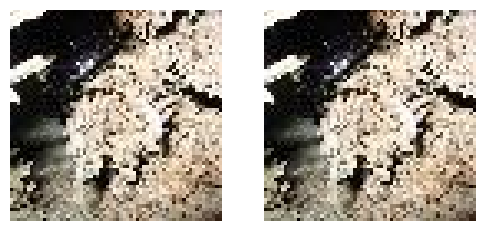

In [8]:
show_images((xb[0], yb[0]));

In [9]:
import math

def conv_size(in_tensor, in_chans, out_chans, ks, stride, pad):
    C_in, H_in, W_in = in_tensor.shape
    H_out = math.floor(((H_in + 2*pad - (ks-1) -1)/stride) + 1)
    W_out = math.floor(((W_in + 2*pad - (ks-1) -1)/stride) + 1)
    return (out_chans, int(H_out), int(W_out))

In [10]:
# Computing conv sizes
nf0 = 64
a = torch.zeros(3, 64, 64)
z = conv_size(a, 3, nf0, 4, 2, 1)
b = torch.zeros(*z)
y = conv_size(b, nf0, nf0*2, 4, 2, 1)
c = torch.zeros(*y)
x = conv_size(c, nf0*2, nf0*4, 4, 2, 1)
d = torch.zeros(*x)
w = conv_size(d, nf0*4, nf0*8, 4, 2, 1)
z, y, x, w


((64, 32, 32), (128, 16, 16), (256, 8, 8), (512, 4, 4))

In [11]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.ConvTranspose2d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)
    
iw = partial(init_weights, leaky=0.2)

In [12]:
def conv(ni, nf):
    return nn.Sequential(nn.Conv2d(ni, nf, 4, 2, 1), nn.BatchNorm2d(nf), nn.LeakyReLU(0.1))

def rev_conv(ni, nf):
    return nn.Sequential(nn.ConvTranspose2d(ni, nf, 4, 2, 1), nn.BatchNorm2d(nf), nn.LeakyReLU(0.1))

In [13]:
class ConvVAE(nn.Module):
    def __init__(self, ni, nf0, z_dim=128):
        super(ConvVAE, self).__init__()

        self.encoder = nn.Sequential(
            conv(ni, nf0),
            conv(nf0, nf0*2),
            conv(nf0*2, nf0*4),
            conv(nf0*4, nf0*8),
            nn.Flatten(),
            nn.Linear(nf0*8*4*4, nf0*16),
            nn.LeakyReLU(0.1),
            nn.Linear(nf0*16, z_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, nf0*16),
            nn.LeakyReLU(0.1),
            nn.Linear(nf0*16, nf0*8*4*4),
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (nf0*8, 4, 4)),
            nn.BatchNorm2d(nf0*8),
            rev_conv(nf0*8, nf0*4),
            rev_conv(nf0*4, nf0*2),
            rev_conv(nf0*2, nf0),
            nn.ConvTranspose2d(nf0, ni, 4, 2, 1)
        )
        iw(self)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [14]:
def kld_loss(inp, x):
    x_hat, mu, lv = inp
    return -0.5 * (1 + lv - mu.pow(2) - lv.exp()).mean()

def bce_loss(inp, x): 
    return F.binary_cross_entropy_with_logits(inp[0], x)

def vae_loss(inp, x): 
    return 0.005*kld_loss(inp, x) + bce_loss(inp, x)

In [15]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets): 
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1
        
metrics = MetricsCB(kld=FuncMetric(kld_loss), bce=FuncMetric(bce_loss))

In [16]:
opt_func = partial(optim.Adam, eps=1e-5)
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision()]
model = ConvVAE(3, 16)
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)

kld,bce,loss,epoch,train
0.475,0.642,0.645,0,train
0.906,0.627,0.632,0,eval
0.693,0.604,0.607,1,train
0.861,0.617,0.622,1,eval
0.707,0.597,0.601,2,train
0.877,0.608,0.613,2,eval
0.655,0.594,0.597,3,train
0.759,0.597,0.601,3,eval
0.613,0.591,0.594,4,train
1.136,0.643,0.649,4,eval


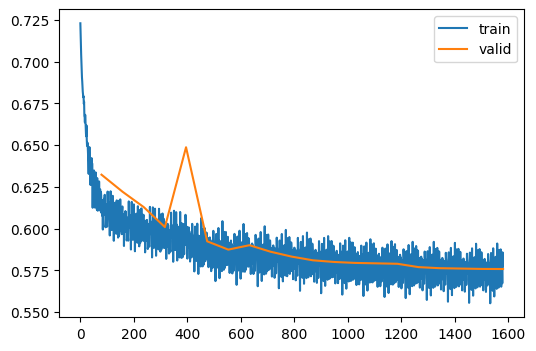

In [17]:
learn.fit(epochs)

##### Adding BatchNorm: 0.581 eval loss
##### Changing ReLU to LeakyReLU: 0.575 eval loss
##### Doubling channels: Gives NaN loss when learning rate was 3e-2

In [18]:
with torch.no_grad(): t,mu,lv = to_cpu(model(xb.cuda()))
t = t.float()

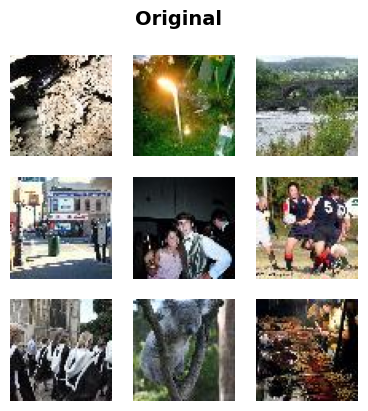

In [19]:
show_images(xb[:9].reshape(-1,3,64,64), imsize=1.5, title='Original');

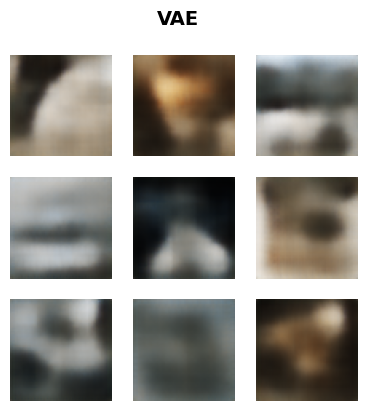

In [20]:
show_images(t[:9].reshape(-1,3,64,64).sigmoid(), imsize=1.5, title='VAE');

In [21]:
noise = torch.randn(9, 128).cuda()
with torch.no_grad(): ims = model.decoder(noise).sigmoid()

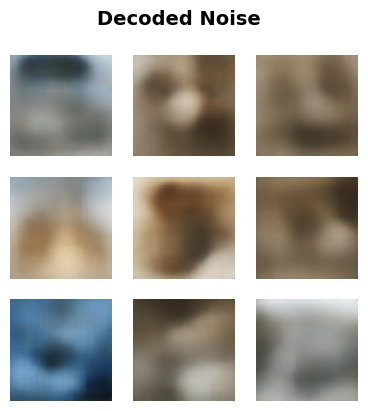

In [22]:
show_images(ims.reshape(-1,3,64,64), imsize=1.5, title="Decoded Noise");